<a href="https://colab.research.google.com/github/Wezz-git/AI-samples/blob/main/Multivariate_Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Business Problem:

Your quant manager was impressed with your Day 7 model but said, "A stock doesn't live in a vacuum. I want a model that predicts $AAPL's price, but it must also consider the S&P 500 and other big tech stocks."

The "Real-World" Skill: This is Multivariate Time Series Forecasting. We're building an LSTM that takes multiple features (columns) as its "lookback" window, not just one.



Data:

- Target: $AAPL (Apple's closing price)

Features:

- $SPY (The S&P 500 market index)

- $MSFT (Microsoft, a related tech giant)

- ^VIX (The "Fear Index" / Volatility)

1 - Import all the tools we need.

2 - Download the data for all four tickers.

3 - Isolate just the 'Close' prices.

4 - Crucially, it will drop any day where one of the assets didn't trade (using .dropna()), so we have a clean, perfectly aligned dataset.

In [15]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 1 - Define the tickers and download the data
tickers = ['AAPL', 'MSFT', 'SPY', '^VIX']
start_date = '2010-01-01'

print("Downloading data...")
data = yf.download(tickers, start=start_date)

# 2 - Isolate the 'close' prices
prices = data['Close'].copy()

# 3 - Clean the data
# Drop any rows where any of the 4 assets didnt trade
# (CRITICAL for multivariate model)
prices = prices.dropna()

# 4 - check the work
print("-- Data Downloaded & Cleaned")
print(prices.head())
print("\n-- Data Summary --")
print(prices.info())

/tmp/ipython-input-3681086198.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date)
[*********************100%***********************]  4 of 4 completed

-- Data Downloaded & Cleaned
Ticker          AAPL       MSFT        SPY       ^VIX
Date                                                 
2010-01-04  6.418383  23.173344  85.279182  20.040001
2010-01-05  6.429478  23.180826  85.504913  19.350000
2010-01-06  6.327211  23.038576  85.565140  19.160000
2010-01-07  6.315515  22.798983  85.926353  19.059999
2010-01-08  6.357501  22.956215  86.212296  18.129999

-- Data Summary --
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3993 entries, 2010-01-04 to 2025-11-14
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    3993 non-null   float64
 1   MSFT    3993 non-null   float64
 2   SPY     3993 non-null   float64
 3   ^VIX    3993 non-null   float64
dtypes: float64(4)
memory usage: 156.0 KB
None


Scale the Data

The LSTM needs all data to be scaled between 0 and 1. Our scaler will learn the "min" and "max" for all four columns at once.

In [16]:
# 1 - create the scaler
# Create one scaler that will learn the min/max for all 4 columns

scaler = MinMaxScaler(feature_range=(0, 1))

# 2 - 'fit' and 'transform' the data
print("Scaling all 4 columns..")

scaled_data = scaler.fit_transform(prices)

print("-- Scaled Data(first 5 rows) --")
print(scaled_data[0:5])

Scaling all 4 columns..
-- Scaled Data(first 5 rows) --
[[0.00244388 0.01102816 0.01261243 0.14819851]
 [0.00248505 0.01104242 0.0129826  0.13881713]
 [0.00210557 0.0107713  0.01308137 0.13623384]
 [0.00206217 0.01031466 0.01367371 0.13487422]
 [0.00221796 0.01061433 0.01414262 0.12222976]]


Create Training & Test "Windows"

(Multivariate): where the X_train "flashcards" will be (60 days, 4 features). We're giving the model much more information to learn from.

compared to:

(Univariate): where the X_train "flashcards" were (60 days, 1 feature)

Next is to:

1 - Build a new LSTM model. (Note: We must change the input_shape to accept our 4 features!)

2 - Compile and train the model.

3 - Make predictions on the test set.

4 - Un-scale the predictions. (This is the trickiest part!)

5 - Plot the results.

Building training 'flashcards'...
Building test 'flashcards'...
--- Data Prep Complete ---
X_train shape: (3135, 60, 4)
y_train shape: (3135,)

Building the Multivariate LSTM model...
Training the model... (This may take a few minutes)
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0073
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.3976e-04
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.3245e-04
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.5561e-04
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.1312e-04
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.0125e-04
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.1314e-04
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.8096e-04
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.6949e-04
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.8731e-04
Making predictions on the test set...
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Un-scaling predictions...

Model RMSE (Root Mean Squared Error): $7.82
Plotting the results...


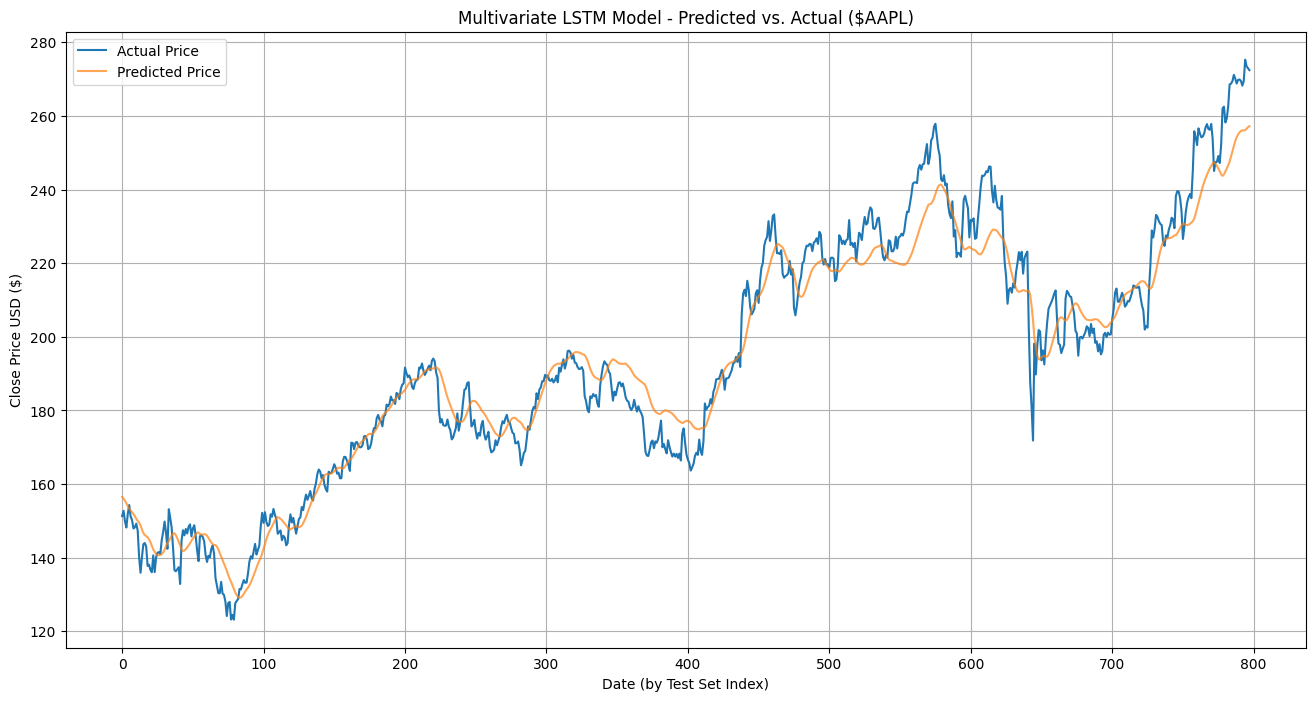

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

# (Assuming 'scaled_data', 'prices', 'scaler', and 'training_data_len' are in memory)

# === 1. DEFINE "WINDOWING" PARAMETERS ===
lookback_period = 60

# 2. CREATE THE DATA SLICES ===
train_data = scaled_data[0:training_data, :]
test_data = scaled_data[training_data - lookback_period:, :]

# 3. BUILD THE "WINDOWS" (X_train, y_train) ===
# We re-initialize the lists to empty, clearing the old, bad data
X_train = []
y_train = []

print("Building training 'flashcards'...")
for i in range(lookback_period, len(train_data)):
    X_train.append(train_data[i-lookback_period:i, :]) # All 4 features
    y_train.append(train_data[i, 0]) # Just the AAPL price
X_train, y_train = np.array(X_train), np.array(y_train)

# 4. BUILD THE "WINDOWS" (X_test, y_test) ===
X_test = []
y_test = prices['AAPL'][training_data:].values

print("Building test 'flashcards'...")
for i in range(lookback_period, len(test_data)):
    X_test.append(test_data[i-lookback_period:i, :])
X_test = np.array(X_test)

# 5. RESHAPE DATA ===
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 4))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 4))

print(f"--- Data Prep Complete ---")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# 6. BUILD THE LSTM MODEL ===
print("\nBuilding the Multivariate LSTM model...")
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 4)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 7. TRAIN THE MODEL (This will now work) ===
print("Training the model... (This may take a few minutes)")
model.fit(X_train, y_train, batch_size=32, epochs=10)

# 8. MAKE PREDICTIONS
print("Making predictions on the test set...")
predictions = model.predict(X_test)

# 9. UN-SCALE & EVALUATE
print("Un-scaling predictions...")
dummy_array = np.zeros((len(predictions), 4))
dummy_array[:, 0] = predictions.flatten()
unscaled_data = scaler.inverse_transform(dummy_array)
unscaled_predictions = unscaled_data[:, 0]

rmse = np.sqrt(mean_squared_error(y_test, unscaled_predictions))
print(f"\nModel RMSE (Root Mean Squared Error): ${rmse:,.2f}")

# 10. PLOT THE RESULTS
print("Plotting the results...")
plot_df = pd.DataFrame({
    'Actual': y_test.flatten(),
    'Predicted': unscaled_predictions.flatten()
})

plt.figure(figsize=(16,8))
plt.title('Multivariate LSTM Model - Predicted vs. Actual ($AAPL)')
plt.xlabel('Date (by Test Set Index)')
plt.ylabel('Close Price USD ($)')
plt.plot(plot_df['Actual'], label='Actual Price')
plt.plot(plot_df['Predicted'], label='Predicted Price', alpha=0.7)
plt.legend()
plt.grid()
plt.show()